<a href="https://colab.research.google.com/github/435wldms/essa/blob/main/20230512_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06 XGBoost

* XGBoost는 트리 기반의 앙상블 학습에서 가장 각광받고 있는 알고리즘 중 하나
* GBM을 기반으로 하고 있지만 GBM의 느린 수행 시간, 과적합 규제 부재 등의 문제를 해결

In [1]:
import xgboost as xgb
from xgboost import XGBClassifier

**파이썬 래퍼 XGBoost 하이퍼 파라미터**

* GBM과 유사한 하이퍼 파라미터를 동일하게 가지고 있으며 여기에 조기 중단, 과적합 규제를 위한 하이퍼 파라미터 등이 추가
>
1) 일반 파라미터 : 디폴트 파라미터 값을 보통 그대로 사용(booster, silent, nthread)
>
2) 부스터 파라미터 : 트리 최적화, 부스팅, regularization 등
>
3) 학습 태스크 파라미터 : 학습 수행 시의 객체 함수, 평가를 위한 지표(eval_metric) 등

* 과적합 문제가 심할 때 : eta 낮춤, max_depth 낮춤, min_child_weight 높임 등

* XGBoost나 LightGBM은 모두 조기 중단 기능이 있어서 GBM과 달리 n_estimators에 지정한 부스팅 반복 횟수에 도달하지 않아도 예측 오류가 더 이상 개선되지 않으면 반복을 끝까지 수행하지 않음.

In [2]:
# xgboost version 확인
import xgboost
print(xgboost.__version__)

1.7.5


**파이썬 래퍼 XGBoost 적용 - 위스콘신 유방암 예측**

* 종양의 크기, 모양 등의 다양한 속성 값을 기반으로 악성 종양인지, 양성 종양인지를 분류한 데이터
* 해당 데이터를 DataFrame으로 로드 후 살펴 봄.

In [3]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target']=y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


-> 결과 : target=0이면 malignant, target=1이면 benign

In [4]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


-> 결과 : 양성이 357개, 악성이 212개로 구성돼 있음.

In [5]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features,y_label, test_size=0.2, random_state=156)
print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


-> 파이썬 래퍼 XGBoost는 사이킷런과 차이가 있는데 가장 큰 차이는 학습&테스트용 데이터 세트를 위해 DMatrix를 생성한다는 점
>
-> 판다스의 DataFrame으로 데이터 인터페이스를 하기 위해서는 DataFrame.values를 이용해 넘파이로 일차 변환 후 DMatrix 변환 적용

In [6]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

* xgb 하이퍼 파라미터부터 설정, 딕셔너리 형태로 입력

In [7]:
params ={
    'max_depth':3,
    'objective': 'binary:logistic',
    'eval_metric':'logloss',
    'early_stoppings':100
}
num_rounds=400

* 위에 지정된 하이퍼 파라미터로 XGBoost 모델 학습시키기 -> xgb.train() 함수에 파라미터로 전달
* 조기 중단을 수행하려면 반드시 evals 파라미터에 eval 데이터 세트 명기

In [8]:
# train 데이터 세트는 'train', evaluation 데이터 세트는 'eval'로 명기.
wlist = [(dtrain,'train'),(dtest,'eval')]

# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds, early_stopping_rounds=100, evals=wlist)

[06:11:23] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stoppings" } are not used.

[0]	train-logloss:0.46775	eval-logloss:0.47984
[1]	train-logloss:0.33578	eval-logloss:0.36218
[2]	train-logloss:0.25254	eval-logloss:0.29004
[3]	train-logloss:0.19584	eval-logloss:0.23382
[4]	train-logloss:0.15664	eval-logloss:0.19901
[5]	train-logloss:0.12663	eval-logloss:0.17469
[6]	train-logloss:0.10353	eval-logloss:0.15549
[7]	train-logloss:0.08545	eval-logloss:0.13367
[8]	train-logloss:0.07277	eval-logloss:0.12411
[9]	train-logloss:0.06333	eval-logloss:0.11611
[10]	train-logloss:0.05484	eval-logloss:0.10768
[11]	train-logloss:0.04787	eval-logloss:0.10018
[12]	train-logloss:0.04334	eval-logloss:0.09754
[13]	train-logloss:0.03794	eval-logloss:0.08920
[14]	train-logloss:0.03308	eval-logloss:0.09259
[15]	train-logloss:0.02942	eval-logloss:0.09144
[16]	train-logloss:0.02689	eval-logloss:0.09066
[17]	train-logloss:0.02439	eval-logloss:0.09058
[18]	train-logloss:0.02226	eval-logloss:0.08894
[19]	

-> 결과 : train()으로 학습을 수행했을때 반복하면서 train-error, eval-logloss가 지속적으로 감소

* xgboost를 이용해 테스트 데이터 세트에 예측 수행
* xgboost에서 predict() 메서드는 예측 결괏값이 아닌 예측 결과를 추정할 수 있는 확률 값을 반환!

In [9]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10],3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds = [1 if x> 0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:', preds[:10])

predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨
[0.978 0.004 0.945 0.054 0.994 1.    1.    1.    0.998 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


* get_clf_eval() 함수를 적용해 XGBoost 모델의 예측 성능 평가

In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [11]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test,pred)
  # ROC - AUC 추가
  roc_auc = roc_auc_score(y_test, pred_proba)
  print('오차 행렬')
  print(confusion)
  # ROC - AUC print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},/ F1: {3:.4f},AUC:{4:4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [12]:
get_clf_eval(y_test, preds, pred_probs)

오차 행렬
[[35  2]
 [ 2 75]]
정확도: 0.9649, 정밀도: 0.9740, 재현율: 0.9740,/ F1: 0.9740,AUC:0.996139


* xgboost 패키지에 내장된 시각화 기능 수행
* plot_importance(): f1 스코어를 기반으로 하는 각 피처의 중요도 나타냄

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

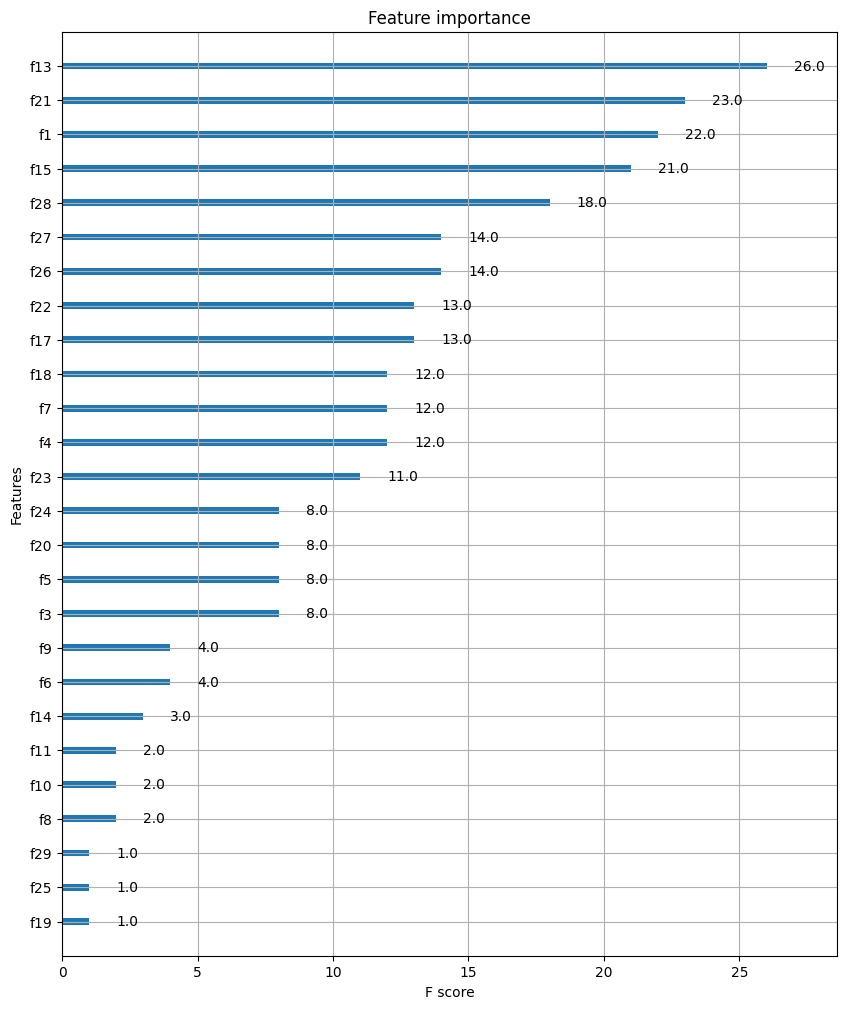

In [13]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax= plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax)

* 파이썬 래퍼 XGBoost는 사이킷런의 GridSearchCV와 유사한 값을 제공 : cv() 

**사이킷런 래퍼 XGBoost의 개요 및 적용**

* 위에서 사용한 파이썬 래퍼와 달리, 사이킷런의 기본 estimator를 그대로 상속해 만들었기 때문에 fit, predict만으로 학습과 예측이 가능
* XGClassifier, XGBRegressor 두 가지 존재


* 유방암 데이터 세트를 분류를 위한 래퍼 클래스인 XGBClassifier를 이용해 예측(n_estimators=400, learning_rate=0.1, max_depth=3)

In [14]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

* get_clf_eval()를 이용해 사이킷런 래퍼 XGBoost로 만들어진 모델 예측 성능 평가

In [15]:
get_clf_eval(y_test, w_preds, w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,/ F1: 0.9806,AUC:0.995086


* 조기 중단을 위해서는 조기 중단 관련한 파라미터를 fit()에 입력
* early_stopping_rounds=100, eval_metric='logloss', eval_set=evals

In [16]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals = [(X_test,y_test)]
xgb_wrapper.fit(X_train, y_train,early_stopping_rounds=100, eval_metric='logloss', eval_set=evals, verbose=True)
ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15472
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

-> 결과: n_estimators=400이지만 311번 반복 후 학습 완료 (100번 반복 동안 성능 평가 지수가 향상되지 않았기 때문)

In [17]:
get_clf_eval(y_test, ws100_preds,ws100_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870,/ F1: 0.9744,AUC:0.995437


-> 조기 중단한 모델과 그렇지 않은 모델 성능이 거의 비슷함
>
-> but 너무 조기 중단값을 급격하게 줄이면 성능 저하 위험

In [18]:
# early_stopping_rounds를 10으로 설정하고 재학습
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='logloss',eval_set=evals,verbose=True)

ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]
get_clf_eval(y_test, ws10_preds, ws10_pred_proba)

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15472
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

* 피처의 중요도를 시각화하는 모듈인 plot_importance()에 사이킷런 래퍼 클래스를 입력해도 파이썬 래퍼의 경우와 같게 시각화 결과를 도출해 줌.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

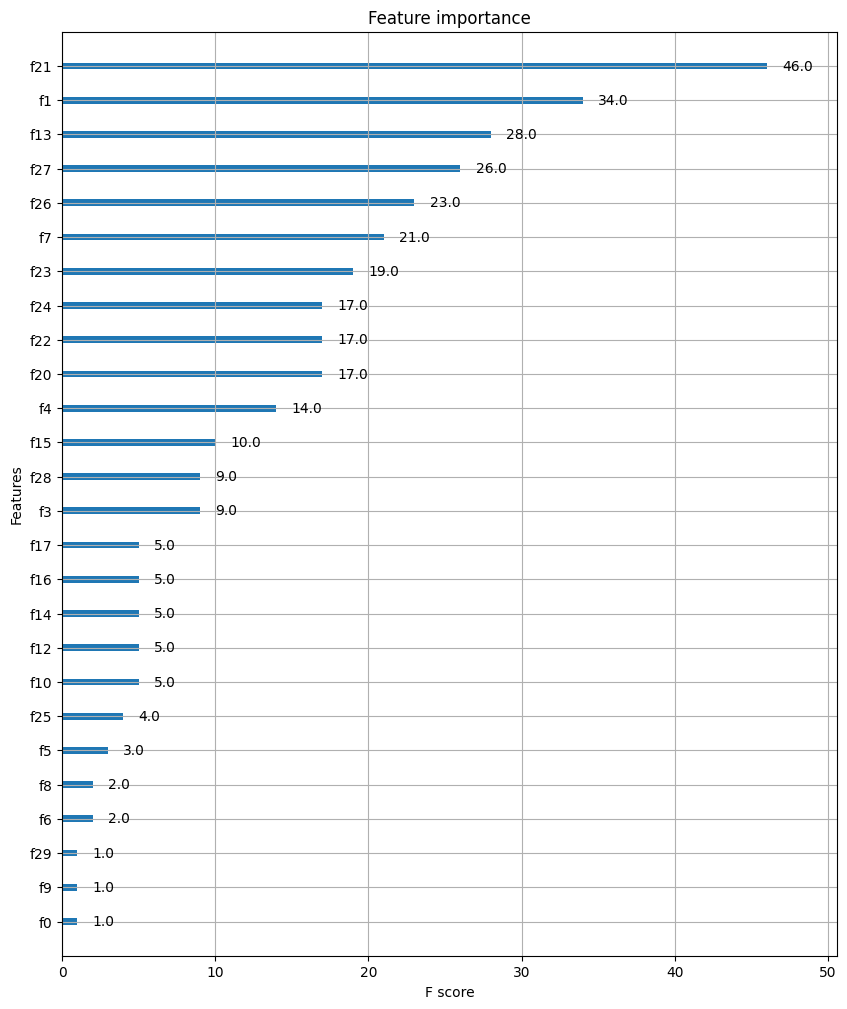

In [19]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))

# 사이킷런 Wrapper 클래스를 입력해도 무방.
plot_importance(xgb_wrapper, ax=ax)

# 07 LightGBM

* XGBoost는 뛰어난 부스팅 알고리즘이지만 하이퍼 파라미터 튜닝을 수행하다 보면 수행시간이 너무 오래 걸려 많은 파라미터 튜닝에 어려움이 있음.
* LightGBM의 큰 장점은 학습에 걸리는 시간이 훨씬 적고, 메모리 사용량도 상대적으로 적음. + 예측 성능은 XGBoost와 유사
* LightGBM은 일반 GBM 계열의 트리 분할 방법(균형 트리 분할)과 다르게 리프 중심 트리 분할 사용 -> 트리의 균형을 맞추지 않고 최대 손실 값을 가지는 리프 노드를 지속적으로 분할하면서 트리의 깊이가 깊어지고 비대칭적인 규칙 트리 생성

**LightGBM 하이퍼 파라미터**

* num_iterations(반복하려는 트리의 개수), learning_rate, max_depth, min_data_in_leaf, num_leaves(하나의 트리가 가질 수 있는 최대 리프 개수)

**하이퍼 파라미터 튜닝 방안**

* num_leaves의 개수를 중심으로 min_child_samples, max_depth를 함께 조작하면서 모델의 복잡도를 줄이는 것이 기본 튜닝 방안

LightGBM 적용 - 위스콘신 유방암 예측

In [20]:
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
ftr=dataset.data
target=dataset.target

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(ftr,target, test_size=0.2,random_state=156)

# 앞서 XGBoost와 동일하게 n_estimators는 400 설정
lgbm_wrapper = LGBMClassifier(n_estimators=400)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능
evals = [(X_test,y_test)]
lgbm_wrapper.fit(X_train, y_train,early_stopping_rounds=100, eval_metric='logloss', eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
pred_proba=lgbm_wrapper.predict_proba(X_test)[:,1]

[1]	valid_0's binary_logloss: 0.565079
[2]	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355773
[7]	valid_0's binary_logloss: 0.329587
[8]	valid_0's binary_logloss: 0.308478
[9]	valid_0's binary_logloss: 0.285395
[10]	valid_0's binary_logloss: 0.267055
[11]	valid_0's binary_logloss: 0.252013
[12]	valid_0's binary_logloss: 0.237018
[13]	valid_0's binary_logloss: 0.224756
[14]	valid_0's binary_logloss: 0.213383
[15]	valid_0's binary_logloss: 0.203058
[16]	valid_0's binary_logloss: 0.194015
[17]	valid_0's binary_logloss: 0.186412
[18]	valid_0's binary_logloss: 0.179108
[19]	valid_0's binary_logloss: 0.174004
[20]	valid_0's binary_logloss: 0.167155
[21]	valid_0's binary_logloss: 0.162494
[22]	valid_0's binary_logloss: 0.156886
[23]	valid_0's binary_logloss: 0.152855
[24]	valid_0's binary_logloss: 0.151113
[25]	valid_0's binary_logloss: 0.148395
[26]	vali

In [21]:
get_clf_eval(y_test,preds,pred_proba)

오차 행렬
[[33  4]
 [ 1 76]]
정확도: 0.9561, 정밀도: 0.9500, 재현율: 0.9870,/ F1: 0.9682,AUC:0.990523


-> 결과: 조기 중단으로 145번 반복 수행 후 학습 종료, 정확도 :약 95.61%

* plot_importance() 이용해 피처 중요도 시각화

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

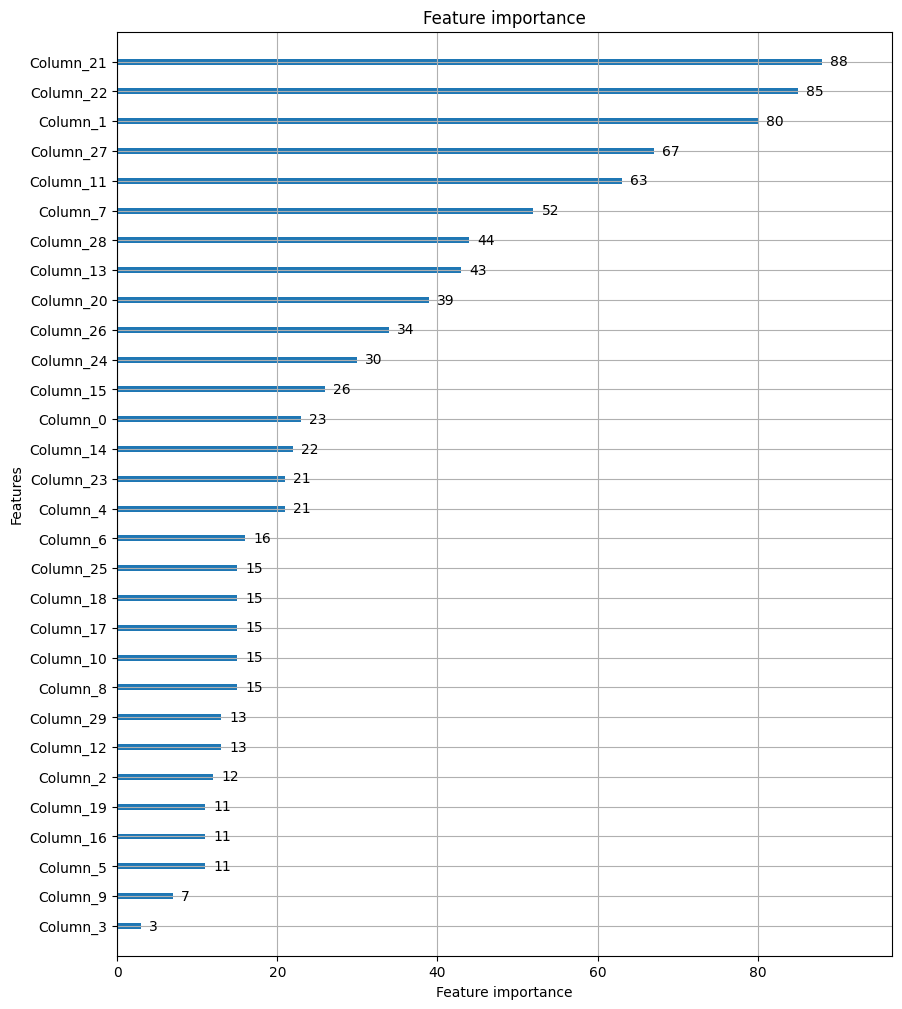

In [22]:
# plot_importance()를 이용해 피처 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper,ax=ax)

# 10 스태킹 앙상블

* 개별적인 여러 알고리즘을 서로 결합해 예측 결과를 도출한다는 것은 배깅, 부스팅과 공통점
* but 개별 알고리즘의 예측 결과 데이터 세트를 최종적 메타 데이터 세트로 만들어 별도의 ML 알고리즘으로 최종 학습을 수행하고 테스트 데이터를 기반으로 다시 최종 예측을 수행한다는 점이 차이
* 두 종류의 모델이 필요 -> 개별적 기반 모델, 기반 모델의 예측 데이터를 학습 데이터로 만들어서 학습하는 최종 메타 모델

**기본 스태킹 모델**

In [23]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data= cancer_data.data
y_label= cancer_data.target 

X_train, X_test, y_train, y_test = train_test_split(X_data, y_label, test_size=0.2, random_state=0)

In [24]:
# 개별 ML 모델 생성
knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

# 스태킹으로 만들어진 데이터 세트를 학습, 예측할 최종 모델
lr_final = LogisticRegression(C=10)

In [25]:
# 개별 모델들을 학습.
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [26]:
# 학습된 개별 모델들이 각자 반환하는 예측 데이터 세트를 생성하고 개별 모델의 정확도 측정
knn_pred=knn_clf.predict(X_test)
rf_pred=rf_clf.predict(X_test)
dt_pred=dt_clf.predict(X_test)
ada_pred=ada_clf.predict(X_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.9211
랜덤포레스트 정확도: 0.9649
결정 트리 정확도: 0.9123
에이다부스트 정확도: 0.9561


* 개별 알고리즘으로부터 예측된 예측 값을 칼럼 레벨로 옆으로 붙여서 피처 값으로 만들어 최종 메타 모델인 로지스틱 회귀에서 학습 데이터로 다시 사용
* 반환된 예측 데이터 세트는 1차원 ndarray이므로 행 -> 열로 변환

In [27]:
pred = np.array([knn_pred,rf_pred,dt_pred,ada_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환. 칼럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦.
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


* 최종 메타 모델인 로지스틱 회귀를 학습하고 예측 정확도 측정,

In [28]:
lr_final.fit(pred,y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, final)))

최종 메타 모델의 예측 정확도: 0.9737


-> 결과: 개별 모델 정확도보다 향상됨

**CV 세트 기반의 스태킹**

* 앞 예제에서 마지막에 메타 모델인 로지스틱 회귀 모델 기반에서 최종 학습 시 레이블 데이터 세트로 테스트용 데이터 세트를 기반으로 학습했기에 과적합 문제 발생 가능
* CV 세트 기반 스태킹은 이에 대한 개선을 위해 개별 모델들이 각각 교차 검증으로 학습용, 테스트용 스태킹 데이터를 생성한 후 이를 기반으로 학습과 예측 수행
>
1) 학습 세트를 검증 폴드 1개와 나머지 학습 폴드로 나눈 후 모델을 학습시키고 검증 폴드를 이용해 예측 결괏값을 구함(최종 학습 데이터), 테스트 세트를 이전에 학습 폴드로 학습시킨 모델을 이용해 테스트 데이터로 예측한 결괏값을 구함(최종 테스트 데이터).
>
2) 위에서 생성한 최종 학습 데이터와 원본 레이블 데이터를 합쳐서 메타 모델을 학습한 후에 최종 테스트 데이터로 예측 수행

* 1단계 구현, get_stacking_base_datasets() 함수를 생성함.

In [29]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
  # 지정된 n_folds값으로 KFold 생성.
  kf = KFold(n_splits=n_folds, shuffle=True, random_state=0)
  # 추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
  train_fold_pred = np.zeros((X_train_n.shape[0],1))
  test_pred = np.zeros((X_test_n.shape[0],n_folds))
  print(model.__class__.__name__,'model 시작')

  for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
    # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
    print('\t 폴드 세트:', folder_counter, '시작')
    X_tr=X_train_n[train_index]
    y_tr=y_train_n[train_index]
    X_te=X_train_n[valid_index]

    # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
    model.fit(X_tr, y_tr)
    # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
    train_fold_pred[valid_index,:] = model.predict(X_te).reshape(-1,1)
    # 입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장.
    test_pred[:,folder_counter] = model.predict(X_test_n)

  # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
  test_pred_mean = np.mean(test_pred,axis=1).reshape(-1,1)

  # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
  return train_fold_pred, test_pred_mean

* 여러 개의 분류 모델 별로 stack_base_model() 함수 수행

In [30]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train,y_train,X_test,7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train,y_train,X_test,7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train,y_train,X_test,7)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train,y_train,X_test,7)

KNeighborsClassifier model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
	 폴드 세트: 5 시작
	 폴드 세트: 6 시작
RandomForestClassifier model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
	 폴드 세트: 5 시작
	 폴드 세트: 6 시작
DecisionTreeClassifier model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
	 폴드 세트: 5 시작
	 폴드 세트: 6 시작
AdaBoostClassifier model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
	 폴드 세트: 5 시작
	 폴드 세트: 6 시작


* 2단계 구현, get_stacking_base_datasets() 호출로 반환된 각 모델별 학습&테스트 데이터를 합침.

In [31]:
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train),axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test),axis=1)
print('원본 학습 피처 데이터 Shape:', X_train.shape,'원본 테스트 피처 Shape',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,'스태킹 테스트 피처 Shape',Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 Shape (114, 4)


-> 결과: 로우 크기는 서로 같고, 4개의 개별 모델 예측값을 합친 것이므로 칼럼은 4개

* 로지스틱회귀를 스태킹 된 학습용 피처 데이터 세트와 원본 학습 레이블 데이터로 학습한 후에 스태킹 된 테스트 데이터 세트로 예측, 결과를 원본 테스트 레이블 데이터와 비교

In [32]:
lr_final.fit(Stack_final_X_train,y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final           )))

최종 메타 모델의 예측 정확도: 0.9737
